In [1]:
import os
import json
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import gymnasium as gym
from gymnasium.wrappers import AtariPreprocessing, FrameStackObservation
import matplotlib.pyplot as plt
import ale_py
print(tf.config.list_physical_devices('GPU'))


[]


In [2]:
class Config:
    SEED = 42
    GAMMA = 0.99  # Discount factor
    EPSILON_START = 1.0
    EPSILON_MIN = 0.1
    EPSILON_DECAY = 0.9995
    BATCH_SIZE = 64
    MAX_STEPS_PER_EPISODE = 10000
    MAX_EPISODES = 100
    LEARNING_RATE = 0.00025
    UPDATE_TARGET_NETWORK = 10000
    MAX_MEMORY_LENGTH = 100000
    METRICS_FILE = "training_metrics.json"
    PLOT_FILE = "training_performance.png"


In [3]:
def create_q_model(input_shape=(4, 84, 84), num_actions=4):
    return keras.Sequential(
        [
            layers.Lambda(
                lambda tensor: keras.ops.transpose(tensor, [0, 2, 3, 1]),
                output_shape=(84, 84, 4),
                input_shape=input_shape,
            ),
            layers.Conv2D(32, 8, strides=4, activation="relu"),
            layers.Conv2D(64, 4, strides=2, activation="relu"),
            layers.Conv2D(64, 3, strides=1, activation="relu"),
            layers.Flatten(),
            layers.Dense(512, activation="relu"),
            layers.Dense(num_actions, activation="linear"),
        ]
    )


In [4]:
class DQNAgent:
    def __init__(self, num_actions, input_shape=(4, 84, 84)):
        self.num_actions = num_actions
        self.model = create_q_model(input_shape, num_actions)
        self.target_model = create_q_model(input_shape, num_actions)

        self.optimizer = keras.optimizers.Adam(
            learning_rate=Config.LEARNING_RATE, clipnorm=1.0
        )
        self.loss_function = keras.losses.Huber()

        # Replay buffers
        self.state_history = []
        self.action_history = []
        self.next_state_history = []
        self.reward_history = []
        self.done_history = []

        # Metrics tracking
        self.training_metrics = []

    def choose_action(self, state, epsilon):
        if np.random.random() < epsilon:
            return np.random.choice(self.num_actions)

        state_tensor = keras.ops.convert_to_tensor(state)
        state_tensor = keras.ops.expand_dims(state_tensor, 0)
        action_probs = self.model(state_tensor, training=False)
        return keras.ops.argmax(action_probs[0]).numpy()

    def store_transition(self, state, action, next_state, reward, done):
        self.state_history.append(state)
        self.action_history.append(action)
        self.next_state_history.append(next_state)
        self.reward_history.append(reward)
        self.done_history.append(done)

        # Limit memory
        if len(self.state_history) > Config.MAX_MEMORY_LENGTH:
            for history in [
                self.state_history,
                self.action_history,
                self.next_state_history,
                self.reward_history,
                self.done_history,
            ]:
                del history[0]

    def train(self, frame_count):
        if len(self.done_history) < Config.BATCH_SIZE:
            return None

        # Sample batch from replay buffer
        indices = np.random.choice(
            range(len(self.done_history)), size=Config.BATCH_SIZE
        )

        state_batch = np.array([self.state_history[i] for i in indices])
        next_state_batch = np.array([self.next_state_history[i] for i in indices])
        reward_batch = [self.reward_history[i] for i in indices]
        action_batch = [self.action_history[i] for i in indices]
        done_batch = keras.ops.convert_to_tensor(
            [float(self.done_history[i]) for i in indices]
        )

        # Compute target Q-values
        future_rewards = self.target_model.predict(next_state_batch)
        updated_q_values = reward_batch + Config.GAMMA * (
            keras.ops.amax(future_rewards, axis=1)
        ) * (1 - done_batch)

        # Create action masks
        masks = keras.ops.one_hot(action_batch, self.num_actions)

        with tf.GradientTape() as tape:
            q_values = self.model(state_batch)
            q_action = keras.ops.sum(keras.ops.multiply(q_values, masks), axis=1)
            loss = self.loss_function(updated_q_values, q_action)

        # Backpropagate
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

        return loss.numpy()

    def update_target_network(self):
        self.target_model.set_weights(self.model.get_weights())

    def log_metrics(self, episode, episode_reward, running_reward, epsilon, loss):
        metrics = {
            "episode": episode,
            "episodeReward": episode_reward,
            "runningReward": running_reward,
            "epsilon": epsilon,
            "loss": float(loss) if loss is not None else None,
        }
        self.training_metrics.append(metrics)

    def save_metrics(self):
        with open(Config.METRICS_FILE, "w") as f:
            json.dump(self.training_metrics, f)

        # Plot training progress
        plt.figure(figsize=(12, 8))

        plt.subplot(2, 2, 1)
        plt.plot(
            [m["episode"] for m in self.training_metrics],
            [m["episodeReward"] for m in self.training_metrics],
        )
        plt.title("Episode Rewards")
        plt.xlabel("Episode")
        plt.ylabel("Reward")

        plt.subplot(2, 2, 2)
        plt.plot(
            [m["episode"] for m in self.training_metrics],
            [m["runningReward"] for m in self.training_metrics],
        )
        plt.title("Running Rewards")
        plt.xlabel("Episode")
        plt.ylabel("Reward")

        plt.subplot(2, 2, 3)
        plt.plot(
            [m["episode"] for m in self.training_metrics],
            [m["epsilon"] for m in self.training_metrics],
        )
        plt.title("Exploration Rate")
        plt.xlabel("Episode")
        plt.ylabel("Epsilon")

        plt.subplot(2, 2, 4)
        losses = [m["loss"] for m in self.training_metrics if m["loss"] is not None]
        plt.plot(range(len(losses)), losses)
        plt.title("Training Loss")
        plt.xlabel("Training Steps")
        plt.ylabel("Loss")

        plt.tight_layout()
        plt.savefig(Config.PLOT_FILE)
        plt.close()


In [5]:
def train_dqn():
    # Set random seeds
    np.random.seed(Config.SEED)
    tf.random.set_seed(Config.SEED)

    gym.register_envs(ale_py)
    # Environment setup
    env = gym.make("ALE/Breakout-v5", frameskip=1)
    env = AtariPreprocessing(env)
    env = FrameStackObservation(env, 4)

    # Agent and environment initialization
    num_actions = env.action_space.n
    agent = DQNAgent(num_actions)

    # Training loop
    frame_count = 0
    episode_count = 0
    running_reward = 0
    episode_reward_history = []
    epsilon = Config.EPSILON_START

    while episode_count < Config.MAX_EPISODES:
        state, _ = env.reset()
        state = np.array(state)
        episode_reward = 0

        for step in range(1, Config.MAX_STEPS_PER_EPISODE):
            frame_count += 1

            # Choose action
            action = agent.choose_action(state, epsilon)

            # Step environment
            next_state, reward, done, _, _ = env.step(action)
            next_state = np.array(next_state)

            # Store transition
            agent.store_transition(state, action, next_state, reward, done)

            # Train
            loss = agent.train(frame_count)

            # Decay epsilon
            epsilon = max(Config.EPSILON_MIN, epsilon * Config.EPSILON_DECAY)

            episode_reward += reward
            state = next_state

            # Update target network periodically
            if frame_count % Config.UPDATE_TARGET_NETWORK == 0:
                agent.update_target_network()

            if done:
                break

        # Track episode rewards
        episode_reward_history.append(episode_reward)
        if len(episode_reward_history) > 100:
            episode_reward_history.pop(0)

        running_reward = np.mean(episode_reward_history)

        # Log metrics for this episode
        agent.log_metrics(episode_count, episode_reward, running_reward, epsilon, loss)

        episode_count += 1

        # Print progress
        if episode_count % 10 == 0:
            print(
                f"Episode {episode_count}: Reward = {episode_reward}, "
                f"Running Reward = {running_reward:.2f}, "
                f"Epsilon = {epsilon:.4f}"
            )

        # Stopping conditions
        if running_reward > 40:
            print(f"Solved at episode {episode_count}!")
            break

    # Save final metrics
    agent.save_metrics()

    return agent


In [6]:
# Main execution
if __name__ == "__main__":
    trained_agent = train_dqn()

c:\Users\catha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━

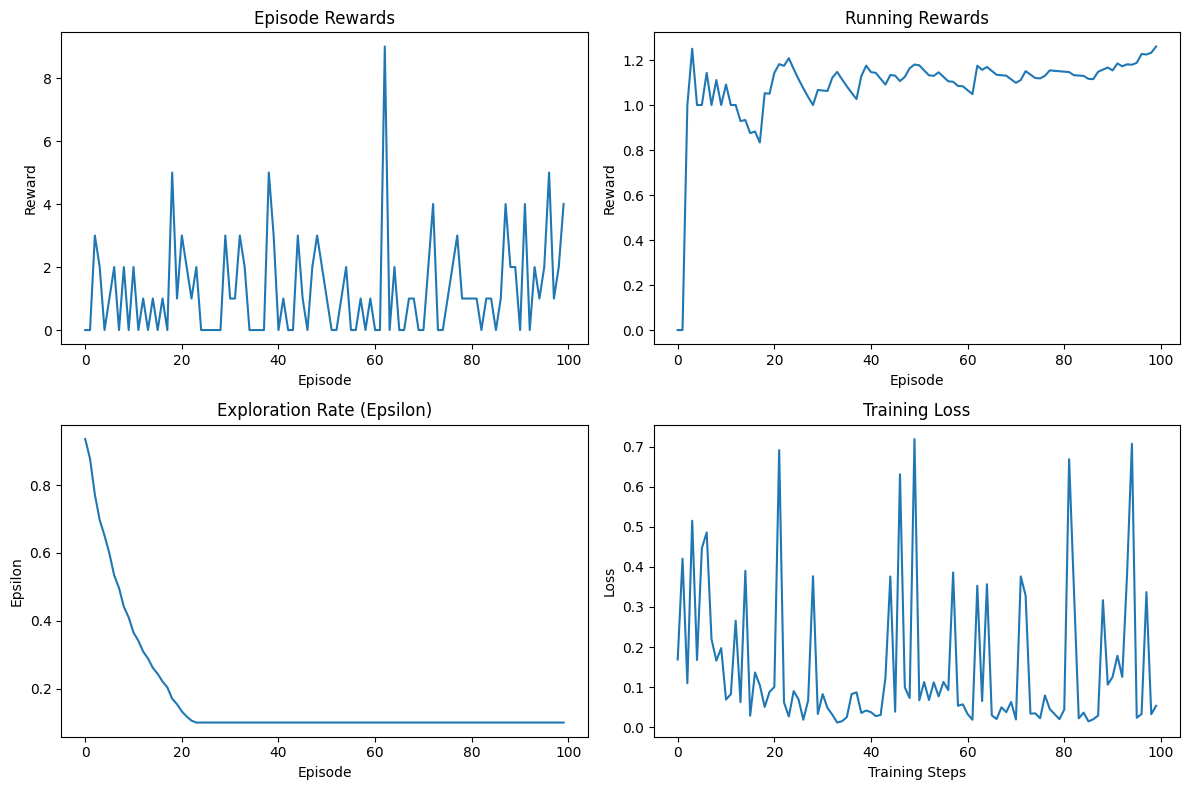

In [7]:
# Plotting the training progress after training is done
metrics = json.load(open(Config.METRICS_FILE))
plt.figure(figsize=(12, 8))

# Episode rewards
plt.subplot(2, 2, 1)
plt.plot([m["episode"] for m in metrics], [m["episodeReward"] for m in metrics])
plt.title("Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")

# Running rewards
plt.subplot(2, 2, 2)
plt.plot([m["episode"] for m in metrics], [m["runningReward"] for m in metrics])
plt.title("Running Rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")

# Exploration rate (epsilon)
plt.subplot(2, 2, 3)
plt.plot([m["episode"] for m in metrics], [m["epsilon"] for m in metrics])
plt.title("Exploration Rate (Epsilon)")
plt.xlabel("Episode")
plt.ylabel("Epsilon")

# Loss curve
plt.subplot(2, 2, 4)
losses = [m["loss"] for m in metrics if m["loss"] is not None]
plt.plot(range(len(losses)), losses)
plt.title("Training Loss")
plt.xlabel("Training Steps")
plt.ylabel("Loss")

plt.tight_layout()
plt.show()